# STARSKØPE

## Part III: MAST API via AWS

**STARSKØPE Phase 3 Objectives**

1. Use datasets from the MAST website (via API) to incorporate other calculations of the star's properties as features to be used for classification algorithms. Furthermore, attempt other types of transformations and normalizations on the data before running the model - for instance, apply a Fourier transform.

2. Combine data from multiple campaigns and perhaps even multiple telescopes (for instance, matching sky coordinates and time intervals between K2, Kepler, and TESS for a batch of stars that have overlapping observations - this would be critical for finding transit periods that are longer than the campaigns of a single telecope's observation period).

MAST archive from STScI: DOI 10.26133/NEA4

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1MuPehwunnqjGgWI9-k30XKXpOKS59neD#scrollTo=tiR_zPCLZRws)

# Import

In [1]:
# Working with http://astroquery.readthedocs.io/en/latest/mast/mast.html
# Make sure you're running the latest version of the following packages:

# astroquery
# astropy
# boto3
# awscli

In [14]:
#!pip install astroquery

In [16]:
#!pip install astropy

In [18]:
#!pip install -U boto3

In [20]:
#!pip install awscli

In [94]:
#!pip install spacekit

In [1]:
def reload(mod):
    """Reloads the module from file without restarting kernel.
        Args:
            mod (loaded mod or list of mod objects): name or handle of package (i.e.,[ pd, fs,np])
        Returns:
            reload each model.
    Example:
    # You pass in whatever name you imported as.
    import my_functions_from_file as mf
    # after editing the source file:
    # mf.reload(mf)"""
    from importlib import reload
    print(f'Reloading...\n')
    
    ## 
    if isinstance(mod,list):
        return [reload(m) for m in mod]
    else:
        return  reload(mod)

In [2]:
import pandas as pd
import numpy as np
import os,glob, sys
import boto3
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astropy.io import fits

# spacekit - my custom python library for astrophysics ML
import spacekit

In [3]:
import matplotlib as mpl
%matplotlib inline
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
 

font_dict={'family':'"Titillium Web", monospace','size':16}
mpl.rc('font',**font_dict)


#ignore pink warnings
import warnings
warnings.filterwarnings('ignore')
# Allow for large # columns
pd.set_option('display.max_columns', 0)
# pd.set_option('display.max_rows','')

In [4]:
os.getcwd()

'/Users/rkein/Code/starskope'

In [5]:
# # If using Jupyter notebook/local
HOME = os.getcwd() #'/Users/rkein/Code/starskope'
os.listdir(HOME)

# # If using Google Colabs
# from google.colab import drive
# drive.mount('/gdrive',force_remount=True)

['LICENSE.md',
 '.DS_Store',
 'config',
 'Nontechnical-capstone.pdf',
 'postman',
 'models',
 '288_planetbleed1600.jpeg',
 'README.md',
 'starskope.ipynb',
 '.gitignore',
 '_config.yml',
 'scripts',
 '._README.md',
 'starskope_3.ipynb',
 'starskope_4.ipynb',
 '.ipynb_checkpoints',
 'spacekit',
 '.git',
 'plot.tbl',
 'DATA',
 'outputs',
 'starskope_2.ipynb',
 'specs.zip']

In [5]:
# # Jupyter Notebook
# %mkdir ~/.aws/config

# # Google Colab
# %cd '/gdrive/My Drive/'
# %mkdir config

In [6]:
# # change the <tags> to your aws info

# text = '''
# [default]
# aws_access_key_id = <YOUR_AWS_KEY_ID> 
# aws_secret_access_key = <YOUR_AWS_ACCESS_KEY>
# region = us-east-1
# '''

In [7]:
# # Jupyter
#path = "~/.aws/config"
# with open(path, 'w') as f:
#    f.write(text)
# !cat ~/.aws/config

# # Google Colabs
# path = "/gdrive/My Drive/config/awscli.ini"
# with open(path, 'w') as f:
#    f.write(text)
# !cat /gdrive/My\ Drive/config/awscli.ini

In [6]:
# # Jupyter
#!export AWS_SHARED_CREDENTIALS_FILE=~/.aws/config
#path = '~/.aws/config'
path = './config/awscli.ini'
!export AWS_SHARED_CREDENTIALS_FILE=./config/awscli.ini
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = path
print(os.environ['AWS_SHARED_CREDENTIALS_FILE'])

# # Google Colabs
# !export AWS_SHARED_CREDENTIALS_FILE=/gdrive/My\ Drive/config/awscli.ini
# path = path
# os.environ['AWS_SHARED_CREDENTIALS_FILE'] = path
# print(os.environ['AWS_SHARED_CREDENTIALS_FILE'])

./config/awscli.ini


Kepler observed parts of a 10 by 10 degree patch of sky near the constellation of Cygnus for four years (17, 3-month quarters) starting in 2009. The mission downloaded small sections of the sky at a 30-minute (long cadence) and a 1-minute (short cadence) in order to measure the variability of stars and find planets transiting these stars. These data are now available in the public s3://stpubdata/kepler/public S3 bucket on AWS.


https://mast-labs.stsci.io/

These data are available under the same terms as the public dataset for Hubble and TESS, that is, if you compute against the data from the AWS US-East region, then data access is free.

In [7]:
# s3://stpubdata/kepler/public
region = 'us-east-1'
s3 = boto3.resource('s3', region_name=region)
bucket = s3.Bucket('stpubdata')
location = {'LocationConstraint': region}

Cloud data access is enabled using the `enable_cloud_dataset` function, which will cause AWS to become the prefered source for data access until it is disabled (`disable_cloud_dataset`).

When cloud access is enabled, the standard download function `download_products` will preferentially pull files from AWS when they are available. There is also a cloud_only flag, which when set to True will cause all data products not available in the cloud to be skipped.

In [8]:
Observations.enable_cloud_dataset(provider='AWS', profile='default')

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]
INFO: See Request Pricing in https://aws.amazon.com/s3/pricing/ for details [astroquery.mast.cloud]
INFO: If you have not configured boto3, follow the instructions here: https://boto3.readthedocs.io/en/latest/guide/configuration.html [astroquery.mast.cloud]


In [37]:
#Observations.disable_cloud_dataset()

This script queries MAST for TESS FFI data for a single sector/camera/chip combination and downloads the data from the AWS public dataset rather than from MAST servers.

In [9]:
# Example query (not using here but helpful)
# catalog_data = Catalogs.query_criteria(catalog="Tic",Bmag=[30,50],objType="STAR")
# print(catalog_data)

    ID    version  HIP TYC ...     e_Dec_orig     raddflag wdflag   objID   
--------- -------- --- --- ... ------------------ -------- ------ ----------
261459129 20190415  --  -- ...  0.200397148604244        1      0 1701625107
 64575709 20190415  --  -- ...   0.21969663115091        1      0  595775997
125413929 20190415  --  -- ...  0.293682765259495        1      0  579825059
 81609218 20190415  --  -- ...  0.146788572369267        1      0  630541794
 94322581 20190415  --  -- ...  0.205286802302475        1      0  606092549
260216294 20190415  --  -- ...  0.187170498094167        1      0  683390717
125414201 20190415  --  -- ...   0.22398993783274        1      0  579825329
123585000 20190415  --  -- ...  0.618316068787371        0      0  574511442
406300991 20190415  --  -- ... 0.0518318978617112        0      0 1411465651
463721073 20190415  --  -- ...  0.489828592248652       -1      1  710312391
282024596 20190415  --  -- ...  0.548806522539047        1      0  573765450

In [9]:
print(Observations.list_missions())

['BEFS', 'EUVE', 'FUSE', 'GALEX', 'HLA', 'HLSP', 'HST', 'HUT', 'IUE', 'JWST', 'K2', 'K2FFI', 'Kepler', 'KeplerFFI', 'PS1', 'SPITZER_SHA', 'SWIFT', 'TESS', 'TUES', 'WUPPE']


In [10]:
target = "K2-1"
#Do a cone search and find the K2 long cadence data for target
obs = Observations.query_object(target,radius="0s")
want = (obs['obs_collection'] == "K2") & (obs['t_exptime'] ==1800.0)

In [11]:
#Pick which data you want to retrieve
data_prod = Observations.get_product_list(obs[want])

In [12]:
data_prod

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid
str10,str2,str10,str20,str37,str1,str97,str9,str28,str8,str1,str2,str2,str63,str34,int64,str10
9500379213,K2,timeseries,ktwo246375295-c12_lc,Preview-Full,S,mast:K2/url/missions/k2/previews/c12/246300000/75000/ktwo246375295-c12_llc_bw_large.png,PREVIEW,--,--,--,K2,39,GO12062_GO12071_GO12085_GO12099_GO12122_GO12124_GO12902_GO12903,ktwo246375295-c12_llc_bw_large.png,23279,9500379213
9500379213,K2,timeseries,ktwo246375295-c12_lc,Lightcurve Long Cadence (KLC) - C12,S,mast:K2/url/missions/k2/lightcurves/c12/246300000/75000/ktwo246375295-c12_llc.fits,SCIENCE,Minimum Recommended Products,LLC,--,K2,39,GO12062_GO12071_GO12085_GO12099_GO12122_GO12124_GO12902_GO12903,ktwo246375295-c12_llc.fits,417600,9500379213
9500379213,K2,timeseries,ktwo246375295-c12_lc,Target Pixel Long Cadence (KTL) - C12,S,mast:K2/url/missions/k2/target_pixel_files/c12/246300000/75000/ktwo246375295-c12_lpd-targ.fits.gz,SCIENCE,Minimum Recommended Products,LPD-TARG,--,K2,39,GO12062_GO12071_GO12085_GO12099_GO12122_GO12124_GO12902_GO12903,ktwo246375295-c12_lpd-targ.fits.gz,6905351,9500379213
9500379213,K2,timeseries,ktwo246375295-c12_lc,Preview-Thumb,S,mast:K2/url/missions/k2/previews/c12/246300000/75000/ktwo246375295-c12_llc_bw_thumb.png,THUMBNAIL,--,--,--,K2,39,GO12062_GO12071_GO12085_GO12099_GO12122_GO12124_GO12902_GO12903,ktwo246375295-c12_llc_bw_thumb.png,2104,9500379213


In [13]:
filt_prod = Observations.filter_products(data_prod, productSubGroupDescription="LLC")

filt_prod

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid
str10,str2,str10,str20,str37,str1,str97,str9,str28,str8,str1,str2,str2,str63,str34,int64,str10
9500379213,K2,timeseries,ktwo246375295-c12_lc,Lightcurve Long Cadence (KLC) - C12,S,mast:K2/url/missions/k2/lightcurves/c12/246300000/75000/ktwo246375295-c12_llc.fits,SCIENCE,Minimum Recommended Products,LLC,--,K2,39,GO12062_GO12071_GO12085_GO12099_GO12122_GO12124_GO12902_GO12903,ktwo246375295-c12_llc.fits,417600,9500379213


In [10]:
# create dir for MAST data
DATA = os.path.abspath(HOME+'/DATA')
#%mkdir './data/mast'
MAST = os.path.abspath(DATA+'/mast')
MAST

'/Users/rkein/Code/starskope/DATA/mast'

In [11]:
# Targets with confirmed exoplanets for K2 mission  
K2_confirmed_planet_hosts = ['K2-1','K2-21','K2-28','K2-39','K2-54','K2-55','K2-57','K2-58',
                        'K2-59','K2-60','K2-61','K2-62','K2-63','K2-64','K2-65','K2-66', 
                        'K2-68','K2-70','K2-71','K2-72','K2-73','K2-74','K2-75','K2-76',
                        'K2-116','K2-167','K2-168','K2-169','K2-170','K2-171','K2-172']

In [12]:
len(K2_confirmed_planet_hosts)

31

# Download from AWS

In [13]:
os.getcwd()

'/Users/rkein/Code/starskope'

In [14]:
os.chdir(MAST)

In [26]:
def get_uris(target_list):
    s3_uris = []
    #Do a cone search and find the K2 long cadence data for each target
    for target in target_list:
        obs = Observations.query_object(target,radius="0s")
        want = (obs['obs_collection'] == "K2") & (obs['t_exptime'] ==1800.0)
        data_prod = Observations.get_product_list(obs[want])
        filt_prod = Observations.filter_products(data_prod, productSubGroupDescription="LLC")
        s3_uris.append(Observations.get_cloud_uris(filt_prod)[0])
    return s3_uris

In [27]:
uris = get_uris(K2_confirmed_planet_hosts)

In [61]:
uris[:5]

['s3://stpubdata/k2/public/lightcurves/c12/246300000/75000/ktwo246375295-c12_llc.fits',
 's3://stpubdata/k2/public/lightcurves/c3/206000000/11000/ktwo206011691-c03_llc.fits',
 's3://stpubdata/k2/public/lightcurves/c3/206300000/18000/ktwo206318379-c03_llc.fits',
 's3://stpubdata/k2/public/lightcurves/c3/206200000/47000/ktwo206247743-c03_llc.fits',
 's3://stpubdata/k2/public/lightcurves/c3/205900000/16000/ktwo205916793-c03_llc.fits']

In [29]:
uris[0]

's3://stpubdata/k2/public/lightcurves/c12/246300000/75000/ktwo246375295-c12_llc.fits'

In [352]:
uris[23]

's3://stpubdata/k2/public/lightcurves/c3/206400000/32000/ktwo206432863-c03_llc.fits'

In [353]:
K2_confirmed_planet_hosts[23]

'K2-76'

In [30]:
len(uris)

31

In [32]:
def download_fits(s3_uris):
    count = 0
    for uri in s3_uris:
        print(f"Downloading {uri}")
        key = uri.replace("s3://stpubdata/", "")
        root = uri.split('/')[-1]
        bucket.download_file(key, root, ExtraArgs={"RequestPayer": "requester"})
        count+=1
    print(f"Download Complete: {count} files")

In [33]:
download_fits(uris)

Download Complete: 31 files to 


In [34]:
os.listdir(MAST)

['ktwo206181769-c03_llc.fits',
 'ktwo206026136-c03_llc.fits',
 'ktwo206209135-c03_llc.fits',
 'ktwo206101302-c03_llc.fits',
 'ktwo206153219-c03_llc.fits',
 'ktwo206245553-c03_llc.fits',
 'ktwo206038483-c03_llc.fits',
 'ktwo246375295-c12_llc.fits',
 'ktwo205924614-c03_llc.fits',
 'ktwo206318379-c03_llc.fits',
 'ktwo206159027-c03_llc.fits',
 'ktwo206247743-c03_llc.fits',
 'ktwo206007892-c03_llc.fits',
 'ktwo205950854-c03_llc.fits',
 'ktwo206027655-c03_llc.fits',
 'ktwo206144956-c03_llc.fits',
 'ktwo206049764-c03_llc.fits',
 'ktwo206082454-c03_llc.fits',
 'ktwo206011691-c03_llc.fits',
 'ktwo206348688-c03_llc.fits',
 'ktwo206044803-c03_llc.fits',
 'ktwo206008091-c03_llc.fits',
 'ktwo206192813-c03_llc.fits',
 'ktwo205916793-c03_llc.fits',
 'ktwo206268299-c03_llc.fits',
 'ktwo205904628-c03_llc.fits',
 'ktwo206432863-c03_llc.fits',
 'ktwo206026904-c03_llc.fits',
 'ktwo206125618-c03_llc.fits',
 'ktwo206096602-c03_llc.fits',
 'ktwo206119924-c03_llc.fits']

In [33]:
## from spacekit.radio import mast_aws
## function for downloading data from MAST s3 bucket on AWS
def mast_aws(target_list):
    import boto3
    from astroquery.mast import Observations
    from astroquery.mast import Catalogs
    # configure aws settings
#     region = 'us-east-1'
#     s3 = boto3.resource('s3', region_name=region)
#     bucket = s3.Bucket('stpubdata')
#     location = {'LocationConstraint': region}
#     Observations.enable_cloud_dataset(provider='AWS', profile='default')
    
    for target in target_list:
    #Do a cone search and find the K2 long cadence data for target
        obs = Observations.query_object(target,radius="0s")
        want = (obs['obs_collection'] == "K2") & (obs['t_exptime'] ==1800.0)
        data_prod = Observations.get_product_list(obs[want])
        filt_prod = Observations.filter_products(data_prod, productSubGroupDescription="LLC")
        s3_uris = Observations.get_cloud_uris(filt_prod)
        for url in s3_uris:
        # Extract the S3 key from the S3 URL
            fits_s3_key = url.replace("s3://stpubdata/", "")
            root = url.split('/')[-1]
            bucket.download_file(fits_s3_key, root, ExtraArgs={"RequestPayer": "requester"})
    #Observations.disable_cloud_dataset()
    return print('Download Complete')

In [87]:
class Radio:
    def __init__(self, target_list):
        self.target_list = target_list


    # function for downloading data from MAST s3 bucket on AWS
    def mast_aws(self):
        import boto3
        from astroquery.mast import Observations
        from astroquery.mast import Catalogs
        # configure aws settings
        region = 'us-east-1'
        s3 = boto3.resource('s3', region_name=region)
        bucket = s3.Bucket('stpubdata')
        location = {'LocationConstraint': region}
        Observations.enable_cloud_dataset(provider='AWS', profile='default')
        
        for target in self.target_list:
        #Do a cone search and find the K2 long cadence data for target
            obs = Observations.query_object(target,radius="0s")
            want = (obs['obs_collection'] == "K2") & (obs['t_exptime'] ==1800.0)
            data_prod = Observations.get_product_list(obs[want])
            filt_prod = Observations.filter_products(data_prod, productSubGroupDescription="LLC")
            s3_uris = Observations.get_cloud_uri(filt_prod)
            for url in s3_uris:
            # Extract the S3 key from the S3 URL
                fits_s3_key = url.replace("s3://stpubdata/", "")
                root = url.split('/')[-1]
                bucket.download_file(fits_s3_key, root, ExtraArgs={"RequestPayer": "requester"})
        Observations.disable_cloud_dataset()
        return print('Download Complete')

In [35]:
# #from spacekit import radio
# radio = Radio(K2_confirmed_planets)
# radio.mast_aws()

In [36]:
# spacekit.radio.mast_aws(K2_confirmed_planets)

# Nasa Exoplanet Archive API

In [ ]:
# https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag=1

In [37]:
import requests

# Getting response from request
#resp = requests.get('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets')
resp = requests.get('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets&select=pl_hostname,ra,dec&where=pl_hostname like K2&format=json')
type(resp)

requests.models.Response

In [38]:
requests.codes.ok

200

In [39]:
print('Response Code:', resp.status_code)
print('Is it OK?', resp.status_code == requests.codes.ok)

Response Code: 200
Is it OK? True


In [40]:

# Note we can only do this becasue r.text() is in JSON format
#r=requests.get('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets&select=pl_hostname,ra,dec&where=pl_facility%like%K2')

r=requests.get("https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets&format=json&select=pl_hostname&where=pl_hostname like '%K2%'")
results = r.json()

In [41]:
# Don't show your IP
results[0]

{'pl_hostname': 'K2-3'}

In [42]:
print(r.url)
display(results[0])

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets&format=json&select=pl_hostname&where=pl_hostname%20like%20'%25K2%25'


{'pl_hostname': 'K2-3'}

In [43]:
targets_df = pd.DataFrame.from_dict(results)

k2_confirmed_total = list(targets_df['pl_hostname'].unique())

In [44]:
targets_df

,pl_hostname
0,K2-3
1,K2-3
2,K2-3
3,K2-25
4,K2-4
...,...
371,K2-263
372,K2-264
373,K2-264
374,K2-233


In [46]:
k2_confirmed_total[:10]

['K2-3',
 'K2-25',
 'K2-4',
 'K2-5',
 'K2-6',
 'K2-7',
 'K2-8',
 'K2-9',
 'K2-19',
 'K2-10']

In [368]:
k2_new_total = k2_confirmed_total

for a in K2_confirmed_planet_hosts:
    if a in k2_confirmed_total:
        k2_new_total.remove(a)

In [369]:
len(k2_new_total)

248

In [373]:
k2_targets = K2_confirmed_planet_hosts

In [375]:
k2_targets.extend(k2_new_total)

In [376]:
len(k2_targets)

279

In [379]:
k2_targets.remove('K2-288 B')

In [380]:
k2_targets.append('K2-288')

In [381]:
# removing targets with error: "Could not resolve K2-XXX to a sky position"
k2_targets.remove('K2-316')
k2_targets.remove('K2-317')
k2_targets.remove('K2-318')
k2_targets.remove('K2-319')
k2_targets.remove('K2-315')
k2_targets.remove('K2-320')
k2_targets.remove('K2-321')
k2_targets.remove('K2-322')
k2_targets.remove('K2-323')
k2_targets.remove('K2-324')
k2_targets.remove('K2-325')
k2_targets.remove('K2-326')

In [382]:
len(k2_targets)

267

In [452]:
k2_targets = sorted(k2_targets)

In [267]:
# Passing parameters

# credentials = {'user_name': ru, 'password': 'password'}
# r = requests.get('', params = credentials)

# Download FITS files from MAST on AWS

In [95]:
def get_uris(target_list):
    s3_uris = []
    #Do a cone search and find the K2 long cadence data for each target
    for target in target_list:
        obs = Observations.query_object(target,radius="0s")
        want = (obs['obs_collection'] == "K2") & (obs['t_exptime'] ==1800.0)
        data_prod = Observations.get_product_list(obs[want])
        filt_prod = Observations.filter_products(data_prod, productSubGroupDescription="LLC")
        try:
            uri = Observations.get_cloud_uris(filt_prod)[0]
            s3_uris.append(uri)
        except ResolverError: 
            print(f"Could not resolve {target} to a sky position.")
            continue
        #s3_uris.append(Observations.get_cloud_uris(filt_prod)[0])
    return s3_uris

In [97]:
def download_fits(s3_uris):
    count = 0
    print(f"Downloading {len(s3_uris)} FITS files from AWS (MAST))")
    for uri in s3_uris:
        key = uri.replace("s3://stpubdata/", "")
        root = uri.split('/')[-1]
        try:
            bucket.download_file(key, root, ExtraArgs={"RequestPayer": "requester"})
            count+=1
        except FileExistsError:
            continue
    print(f"Download Complete: {count} files")

In [98]:
# k2_batch1_targets = get_uris(k2_targets1)
# download_fits(k2_batch1_targets)

Download Complete: 100 files


In [101]:
# k2_batch2_targets = get_uris(k2_targets2)
# download_fits(k2_batch2_targets)

Download Complete: 100 files


In [126]:
# k2_batch3_targets = get_uris(k2_targets3)
# download_fits(k2_batch3_targets)

Download Complete: 65 files


In [ ]:
k2_target_uris = get_uris(k2_targets)
download_fits(k2_target_uris)

In [127]:
Observations.disable_cloud_dataset()

In [289]:
# retrieve the remaining 166
# radio.mast_aws(k2_targets[100:])

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]
INFO: See Request Pricing in https://aws.amazon.com/s3/pricing/ for details [astroquery.mast.cloud]
INFO: If you have not configured boto3, follow the instructions here: https://boto3.readthedocs.io/en/latest/guide/configuration.html [astroquery.mast.cloud]


Download Complete


https://arxiv.org/abs/1810.08835
TESS's Sector 2 (Aug 22 - Sep 20, 2018) and K2 Campaign 19 (Sep 7 - Sep 26, 2018). The overlap region was 0.5 sq. deg. We identified 171 K2 targets that fell inside TESS Sector 2 field of view, all of which are observed at 30-minute cadence by both missions. The targets range in brightness in the TESS bandpass (Tmag) from 6.7-18.4, with 93 targets brighter than Tmag=15, and 17 brighter than Tmag=12. This dataset provides the first simultaneous, long-duration, high-precision observations of the same targets from different space-based observatories and presents an excellent opportunity to explore instrumental systematics present in the two telescopes.

In [448]:
batch_filenames = []
for file in k2_target_uris:
    batch_filenames.append(os.path.basename(file))

In [438]:
targets_files = list(zip(k2_targets, batch_filenames))

In [439]:
targets_files[0]

('K2-10', 'ktwo201577035-c01_llc.fits')

In [496]:
target_dict = {}
for (target, file) in targets_files:
    for uri in k2_target_uris:
        target_dict[target] = [file, uri]

In [497]:
df_target = pd.DataFrame.from_dict(target_dict, orient='index', columns={'file', 'uri'})

In [498]:
df_target

,file,uri
K2-10,ktwo201577035-c01_llc.fits,s3://stpubdata/k2/public/lightcurves/c12/24630...
K2-100,ktwo211990866-c05_llc.fits,s3://stpubdata/k2/public/lightcurves/c12/24630...
K2-101,ktwo211913977-c05_llc.fits,s3://stpubdata/k2/public/lightcurves/c12/24630...
K2-102,ktwo211970147-c05_llc.fits,s3://stpubdata/k2/public/lightcurves/c12/24630...
K2-104,ktwo211969807-c05_llc.fits,s3://stpubdata/k2/public/lightcurves/c12/24630...
...,...,...
K2-97,ktwo211351816-c05_llc.fits,s3://stpubdata/k2/public/lightcurves/c12/24630...
K2-98,ktwo211391664-c05_llc.fits,s3://stpubdata/k2/public/lightcurves/c12/24630...
K2-99,ktwo212803289-c06_llc.fits,s3://stpubdata/k2/public/lightcurves/c12/24630...
K2-1,ktwo206432863-c03_llc.fits,s3://stpubdata/k2/public/lightcurves/c12/24630...


In [491]:
import pickle
os.chdir(DATA)
df_target.to_pickle("k2_target_df.pkl")

In [489]:
os.remove('k2_target_df.pkl')

In [492]:
mast_files = os.listdir(MAST)

In [493]:
mast_files[0]

'ktwo204890128-c02_llc.fits'

In [494]:
len(mast_files)

267

# Campaign 3

In [542]:
os.chdir(MAST)

In [583]:
campaign3 = []
for (target, file) in targets_files:
    if file.split('_')[0].split('-c')[-1] == '03':
        campaign3.append(target)

In [584]:
campaign3

['K2-116',
 'K2-167',
 'K2-168',
 'K2-169',
 'K2-170',
 'K2-171',
 'K2-172',
 'K2-21',
 'K2-265',
 'K2-28',
 'K2-39',
 'K2-54',
 'K2-55',
 'K2-57',
 'K2-58',
 'K2-59',
 'K2-60',
 'K2-61',
 'K2-62',
 'K2-63',
 'K2-64',
 'K2-65',
 'K2-66',
 'K2-68',
 'K2-69',
 'K2-70',
 'K2-71',
 'K2-72',
 'K2-73',
 'K2-74',
 'K2-75',
 'K2-1']

In [585]:
len(campaign3)

32

In [586]:
c3_files = []
for target in campaign3:
    c3_files.append(df_target['file'].loc[target])
c3_files

['ktwo206119924-c03_llc.fits',
 'ktwo205904628-c03_llc.fits',
 'ktwo205950854-c03_llc.fits',
 'ktwo206007892-c03_llc.fits',
 'ktwo206008091-c03_llc.fits',
 'ktwo206049764-c03_llc.fits',
 'ktwo206082454-c03_llc.fits',
 'ktwo206011691-c03_llc.fits',
 'ktwo206011496-c03_llc.fits',
 'ktwo206318379-c03_llc.fits',
 'ktwo206247743-c03_llc.fits',
 'ktwo205916793-c03_llc.fits',
 'ktwo205924614-c03_llc.fits',
 'ktwo206026136-c03_llc.fits',
 'ktwo206026904-c03_llc.fits',
 'ktwo206027655-c03_llc.fits',
 'ktwo206038483-c03_llc.fits',
 'ktwo206044803-c03_llc.fits',
 'ktwo206096602-c03_llc.fits',
 'ktwo206101302-c03_llc.fits',
 'ktwo206125618-c03_llc.fits',
 'ktwo206144956-c03_llc.fits',
 'ktwo206153219-c03_llc.fits',
 'ktwo206159027-c03_llc.fits',
 'ktwo206162305-c03_llc.fits',
 'ktwo206181769-c03_llc.fits',
 'ktwo206192813-c03_llc.fits',
 'ktwo206209135-c03_llc.fits',
 'ktwo206245553-c03_llc.fits',
 'ktwo206268299-c03_llc.fits',
 'ktwo206348688-c03_llc.fits',
 'ktwo206432863-c03_llc.fits']

In [537]:
k2_1 = df_target['file'].loc['K2-1']

In [540]:
k2_1

'ktwo206432863-c03_llc.fits'

In [538]:
k2_21 = df_target['file'].loc['K2-21']

In [539]:
k2_21

'ktwo206011691-c03_llc.fits'

# Light Curves

In [543]:
#fits_file = 'ktwo204890128-c02_llc.fits'
#fits_file = 'ktwo246067459-c12_llc.fits'
fits_file = k2_1
# hdul = fits.open(fits_image_filename)
# hdul.info()

with fits.open(fits_file) as hdul:
    hdul.info()

Filename: ktwo206432863-c03_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3386R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (13, 12)   int32   


In [544]:
hdul[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E13.6'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; uni

In [545]:
from astropy.timeseries import TimeSeries
ts = TimeSeries.read(fits_file, format='kepler.fits') 

In [546]:
ts

time,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2014-11-15T14:28:43.504,5.500672e-03,99599,7.9768555e+04,8.3463850e+00,3.2380928e+03,1.7390656e+00,nan,nan,10000000000000000000,799.48240,4.4634020e-05,153.42342,8.5304688e-05,799.49988,1.2932622e-04,153.44015,1.3487531e-04,2.2890513e-01,1.2846431e-01
2014-11-15T14:58:08.869,5.499438e-03,99600,7.9771562e+04,8.3496199e+00,3.2398108e+03,1.7431647e+00,8.3294992e+04,8.6293488e+00,0,799.47295,4.5078839e-05,153.42841,8.5176813e-05,799.48929,1.2928569e-04,153.44470,1.3495611e-04,2.1829958e-01,1.3245548e-01
2014-11-15T15:27:34.216,5.498203e-03,99601,7.9763500e+04,8.3481474e+00,3.2418232e+03,1.7391915e+00,8.3271242e+04,8.6357679e+00,0,799.46613,4.5598637e-05,153.42997,8.5196341e-05,799.48179,1.2925289e-04,153.44645,1.3501516e-04,2.1089090e-01,1.3368435e-01
2014-11-15T15:56:59.581,5.496969e-03,99602,7.9804828e+04,8.3500891e+00,3.2373269e+03,1.7485135e+00,8.3339773e+04,8.6351480e+00,0,799.45315,4.6974477e-05,153.43976,8.3868639e-05,799.46677,1.2911676e-04,153.45467,1.3504918e-04,1.9658583e-01,1.4168289e-01
2014-11-15T16:26:24.938,5.495733e-03,99603,7.9794445e+04,8.3473330e+00,3.2444006e+03,1.7434516e+00,8.3292219e+04,8.6420383e+00,0,799.44336,4.8108224e-05,153.44258,8.3144652e-05,799.45645,1.2908764e-04,153.45743,1.3513883e-04,1.8613765e-01,1.4411046e-01
2014-11-15T16:55:50.285,5.494496e-03,99604,7.9797664e+04,8.3486977e+00,3.2384539e+03,1.7409093e+00,8.3278039e+04,8.6445456e+00,0,799.43085,4.9026043e-05,153.44986,8.1265978e-05,799.44256,1.2897524e-04,153.46384,1.3524739e-04,1.7281073e-01,1.5053929e-01
2014-11-15T17:25:15.650,5.493259e-03,99605,7.9809336e+04,8.3465929e+00,3.2388191e+03,1.7380608e+00,8.3284953e+04,8.6406479e+00,0,799.41543,4.9929815e-05,153.45852,7.9556099e-05,799.42570,1.2884363e-04,153.47157,1.3533125e-04,1.5609671e-01,1.5769854e-01
2014-11-15T17:54:41.006,5.492021e-03,99606,7.9821688e+04,8.3517170e+00,3.2359521e+03,1.7459368e+00,8.3297836e+04,8.6503124e+00,0,799.39811,5.1180203e-05,153.47006,7.9128426e-05,799.40694,1.2872764e-04,153.48209,1.3541868e-04,1.3717914e-01,1.6877685e-01


In [547]:
ts['time', 'sap_flux', 'sap_flux_err']

time,sap_flux,sap_flux_err
,electron / s,electron / s
object,float32,float32
2014-11-15T14:28:43.504,7.9768555e+04,8.3463850e+00
2014-11-15T14:58:08.869,7.9771562e+04,8.3496199e+00
2014-11-15T15:27:34.216,7.9763500e+04,8.3481474e+00
2014-11-15T15:56:59.581,7.9804828e+04,8.3500891e+00
2014-11-15T16:26:24.938,7.9794445e+04,8.3473330e+00
2014-11-15T16:55:50.285,7.9797664e+04,8.3486977e+00
2014-11-15T17:25:15.650,7.9809336e+04,8.3465929e+00
2014-11-15T17:54:41.006,7.9821688e+04,8.3517170e+00


Text(0, 0.5, 'SAP Flux (e-/s)')

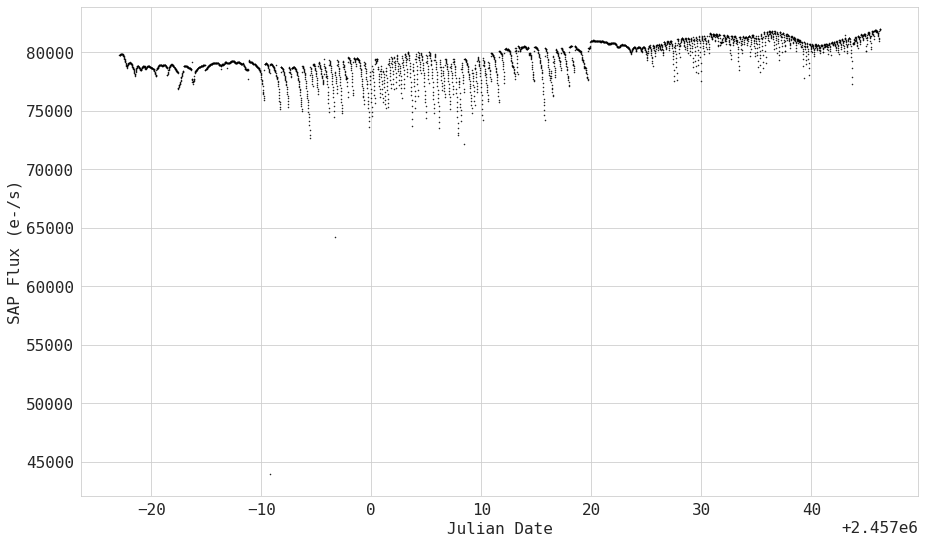

In [548]:
fig = plt.figure(figsize=(15,9))
plt.plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')

## Box Least Squares

In [549]:
# use box least squares to estimate period
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux','sap_flux_err')

In [550]:
results = periodogram.autopower(0.2 * u.day)  
best = np.argmax(results.power)  
period = results.period[best] 
duration = results.duration[best]
transit_time = results.transit_time[best]  

In [551]:
# peak statistics
print(f'period: {np.round(period, 3)}')
print(f'duration: {duration}')
print(f'transit: {transit_time}')

period: 28.87 d
duration: 0.2 d
transit: 2014-11-29T05:21:31.504


In [552]:
print(f'transit time (JD): {np.round(transit_time.jd)}')
print(f'transit time (MJD): {np.round(transit_time.mjd)}')

transit time (JD): 2456991.0
transit time (MJD): 56990.0


In [553]:
# fold the time series using the period 
ts_folded = ts.fold(period=period, epoch_time=transit_time)

Text(0, 0.5, 'SAP Flux (e-/s)')

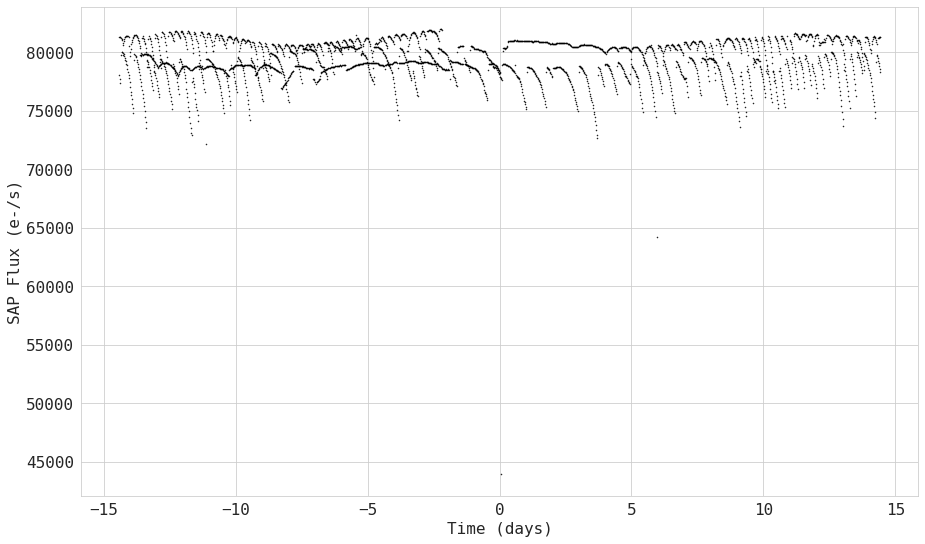

In [554]:
fig = plt.figure(figsize=(15,9))
plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
plt.xlabel('Time (days)')
plt.ylabel('SAP Flux (e-/s)')

In [555]:
#normalize the flux by sigma-clipping the data to determine the baseline flux:
from astropy.stats import sigma_clipped_stats
mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])  
ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median  

In [556]:
# downsample the time series by binning the points into bins of equal time 
# - this returns a BinnedTimeSeries:
from astropy.timeseries import aggregate_downsample
ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.03 * u.day)  
ts_binned

time_bin_start,time_bin_size,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2,sap_flux_norm
,s,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,
object,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-14.417320570818971,2592.0000000000023,0.0019018996972590685,101680,79603.65625,8.397594451904297,4435.31689453125,1.773240089416504,83346.28125,8.792403221130371,0,799.3709373047595,6.116450094850734e-05,153.2776179194962,7.070032734191045e-05,799.4017262603634,0.00013186455180402845,153.32269273569386,0.00013967958511784673,0.10486967861652374,-0.01996821165084839,1.0039499998092651
-14.387320570818972,2591.9999999999977,0.0018989373929798603,101681,79326.28125,8.38899040222168,4436.1796875,1.7791523933410645,83340.921875,8.78489875793457,0,799.36329113853,6.325294089037925e-05,153.28520538993195,6.744185520801693e-05,799.4016302961022,0.00013227370800450444,153.32769718368695,0.0001400955079589039,0.09658189117908478,-0.012889780104160309,1.0004518032073975
-14.35732057081897,2591.9999999999977,0.0018959748558700085,101683,80527.34375,8.434674263000488,4437.6259765625,1.7819409370422363,83328.1484375,8.852641105651855,262144,799.1605844378848,7.229168841149658e-05,153.4599171287,8.021256508072838e-05,799.1846205464725,0.00013087058323435485,153.47820727787942,0.00013859062164556235,-0.12410431355237961,0.15793728828430176,1.0155994892120361
-14.327320570818971,2592.0000000000023,0.0018930119695141912,101684,80528.015625,8.434246063232422,4437.96435546875,1.7836132049560547,83348.5,8.829499244689941,0,799.1346123510231,6.904549081809819e-05,153.474114731628,7.859259494580328e-05,799.165048083795,0.00013116704940330237,153.49601670543046,0.00013859954196959734,-0.14473961293697357,0.17407307028770447,1.0156080722808838
-14.297320570818972,2592.0000000000023,0.0018900487339124084,101686,80274.84375,8.424860000610352,4438.27783203125,1.7771204710006714,83366.7890625,8.792025566101074,262144,799.39939662403,5.5372533097397536e-05,153.27156664373098,8.415411866735667e-05,799.4038819470255,0.00013160193338990211,153.32311673920583,0.00013891364505980164,0.11632545292377472,-0.03676331788301468,1.0124150514602661
-14.26732057081897,2591.9999999999977,0.001887085265479982,101687,80411.34375,8.426925659179688,4442.13427734375,1.7693241834640503,83379.640625,8.811727523803711,4096,799.3985429300867,5.3713003580924124e-05,153.26489736596903,8.148634515237063e-05,799.4071181159034,0.0001312327804043889,153.31501440559674,0.00013860815670341253,0.12666012346744537,-0.03787408024072647,1.014136552810669
-14.237320570818971,2592.0,0.00188412144780159,101689,80388.3515625,8.429823875427246,4442.2216796875,1.7802624702453613,83323.828125,8.819391250610352,0,799.379637259886,5.416624480858445e-05,153.2782739475351,8.324642112711444e-05,799.3858527930743,0.00013114670582581311,153.3256231338096,0.0001386925287079066,0.11007142812013626,-0.02436129003763199,1.013846516609192
-14.207320570818972,2592.0,0.0018811571644619107,101690,80341.203125,8.427919387817383,4441.60546875,1.7825775146484375,83298.7578125,8.822879791259766,0,799.3623606375871,5.770066491095349e-05,153.28980557060004,8.150291978381574e-05,799.3700988075057,0.0001310942170675844,153.3334509797264,0.00013874759315513074,0.09409298002719879,-0.013300798833370209,1.013251781463623


Text(0, 0.5, 'Normalized flux')

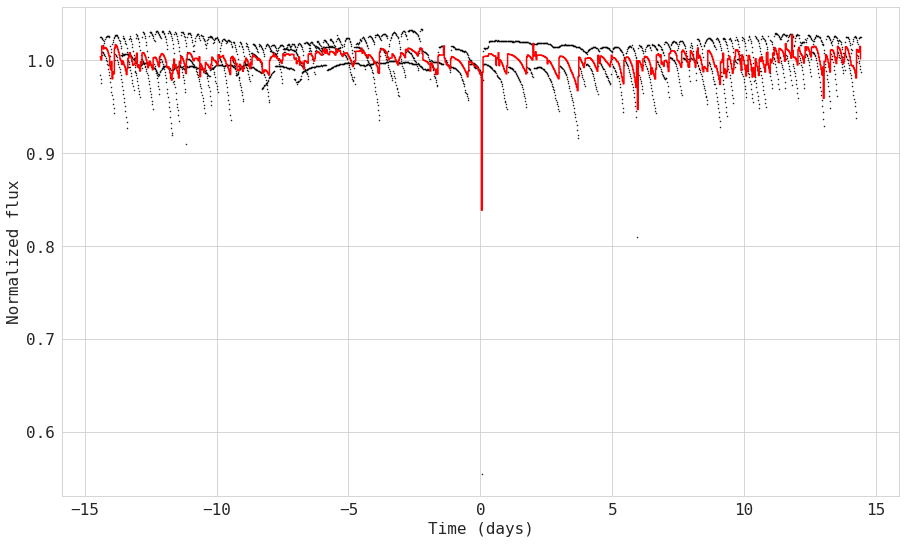

In [557]:
# final result
fig = plt.figure(figsize=(15,9))
plt.plot(ts_folded.time.jd, ts_folded['sap_flux_norm'], 'k.', markersize=1)
plt.plot(ts_binned.time_bin_start.jd, ts_binned['sap_flux_norm'], 'r', drawstyle='steps-post')
plt.xlabel('Time (days)')
plt.ylabel('Normalized flux')

In [560]:
from astropy.timeseries import TimeSeries
import numpy as np
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import aggregate_downsample

In [562]:
#meta = [['obs_id','campaign','lc_start','lc_end','transit_time','period','maxpow']]

# read in file
obs = {}
meta = {}

In [563]:
file = k2_21
filename = test_file
prefix = test_file.replace('ktwo','') 
suffix = prefix.replace('_llc.fits','')
pair = suffix.split('-')
campaign = pair[1]
obs_id = pair[0]
ts = TimeSeries.read(test_file, format='kepler.fits') # read in timeseries

In [564]:
ts

time,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2014-08-23T18:48:58.562,4.849409e-03,95497,nan,nan,nan,nan,nan,nan,10000000000000000100,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-08-23T19:18:23.908,4.847954e-03,95498,nan,nan,nan,nan,nan,nan,100,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-08-23T19:47:49.245,4.846498e-03,95499,nan,nan,nan,nan,nan,nan,100,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-08-23T20:17:14.573,4.845042e-03,95500,nan,nan,nan,nan,nan,nan,100,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-08-23T20:46:39.919,4.843586e-03,95501,nan,nan,nan,nan,nan,nan,100,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-08-23T21:16:05.256,4.842129e-03,95502,nan,nan,nan,nan,nan,nan,100,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-08-23T21:45:30.594,4.840672e-03,95503,nan,nan,nan,nan,nan,nan,100,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2014-08-23T22:14:55.931,4.839214e-03,95504,nan,nan,nan,nan,nan,nan,100,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [565]:
ts['sap_flux_err']

<Quantity [      nan,       nan,       nan, ..., 12.190362, 12.171987,
           12.146645] electron / s>

In [566]:
cols = list(ts.columns)

In [567]:
cols

['time',
 'timecorr',
 'cadenceno',
 'sap_flux',
 'sap_flux_err',
 'sap_bkg',
 'sap_bkg_err',
 'pdcsap_flux',
 'pdcsap_flux_err',
 'sap_quality',
 'psf_centr1',
 'psf_centr1_err',
 'psf_centr2',
 'psf_centr2_err',
 'mom_centr1',
 'mom_centr1_err',
 'mom_centr2',
 'mom_centr2_err',
 'pos_corr1',
 'pos_corr2']

In [568]:
# add to meta dict
meta['fits'] = filename
meta['obs_id'] = obs_id
meta['campaign'] = campaign
meta['lc_start'] = ts.time.jd[0]
meta['lc_end'] = ts.time.jd[-1]
meta['t_start'] = ts.time[0]
meta['t_end'] = ts.time[-1]

In [590]:
meta

{'fits': 'ktwo204890128-c02_llc.fits',
 'obs_id': '204890128',
 'campaign': 'c02',
 'lc_start': 2456893.2840111293,
 'lc_end': 2456972.0484506935,
 't_start': <Time object: scale='tdb' format='isot' value=2014-08-23T18:48:58.562>,
 't_end': <Time object: scale='tdb' format='isot' value=2014-11-10T13:09:46.140>,
 'maxpower': 74771,
 'period': <Quantity 38.82536845 d>,
 'transit': <Time object: scale='tdb' format='isot' value=2014-08-27T18:51:17.398>}

In [570]:
if 'sap_flux_err' in list(ts.columns):
    periodogram = BoxLeastSquares.from_timeseries(ts,'sap_flux','sap_flux_err')
else:
    periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')

In [571]:
periodogram

In [572]:
snr = False

In [573]:
if snr is True:
    results = periodogram.autopower(0.2*u.day, objective='snr')
else:
    results = periodogram.autopower(0.2*u.day)

In [574]:
results

          depth: <Quantity [  1948.51071465,   1966.98486962,   1959.08280705, ...,
           170795.48609894, 172823.29083405, 170805.96604532] electron / s>
      depth_err: <Quantity [0.38940918, 0.38940803, 0.38940802, ..., 1.31071744, 1.31804772,
           1.31063191] electron / s>
      depth_snr: <Quantity [  5003.76161931,   5051.21803084,   5030.92571321, ...,
           130306.86879617, 131120.66277853, 130323.36929339]>
       duration: <Quantity [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2] d>
 log_likelihood: <Quantity [2.51231771e+07, 2.55758107e+07, 2.53703432e+07, ...,
           8.68603559e+09, 8.79256137e+09, 8.68826234e+09]>
      objective: 'likelihood'
         period: <Quantity [ 0.4       ,  0.40000529,  0.40001059, ..., 38.77555084,
           38.82536845, 38.87531423] d>
          power: <Quantity [2.51231771e+07, 2.55758107e+07, 2.53703432e+07, ...,
           8.68603559e+09, 8.79256137e+09, 8.68826234e+09]>
   transit_time: <Time object: scale='tdb' format='isot' val

In [575]:
maxpower = np.argmax(results.power)  
period = results.period[maxpower] 
transit_time = results.transit_time[maxpower]
meta['maxpower'] = maxpower
meta['period'] = period
meta['transit'] = transit_time

In [698]:
c3_small = c3_files[:3]

In [815]:
def planet_hunter(file_list=files, fmt='kepler.fits', error=False, snr=False, verbose=False): #,verbose=False):
    """
    planet_hunter(f=files[9], fmt='kepler.fits')
    
    args:
    - fits_files = takes array or single .fits file
    
    kwargs:
    - format : 'kepler.fits' or  'tess.fits'
    """
    from astropy.timeseries import TimeSeries
    import numpy as np
    from astropy import units as u
    from astropy.timeseries import BoxLeastSquares
    from astropy.stats import sigma_clipped_stats
    from astropy.timeseries import aggregate_downsample

    #meta = [['obs_id','campaign','lc_start','lc_end','transit_time','period','maxpow']]
    
    # read in file
    transits = {}
    for index, file in enumerate(file_list):
        res = {}
        prefix = file.replace('ktwo','') 
        suffix = prefix.replace('_llc.fits','')
        pair = suffix.split('-')
        obs_id = pair[0]
        campaign = pair[1]
        
        ts = TimeSeries.read(file, format=fmt) # read in timeseries
        
        # add to meta dict
        res['obs_id'] = obs_id
        res['campaign'] = campaign
        res['lc_start'] = ts.time.jd[0]
        res['lc_end'] = ts.time.jd[-1]
  
        # use box least squares to estimate period
        if error is True: # if error col data available
            periodogram = BoxLeastSquares.from_timeseries(ts,'sap_flux','sap_flux_err')
        else:
            periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')
        if snr is True:
            results = periodogram.autopower(0.2*u.day, objective='snr')
        else:
            results = periodogram.autopower(0.2*u.day)
        
        maxpower = np.argmax(results.power)  
        period = results.period[maxpower] 
        transit_time = results.transit_time[maxpower]
        duration = results.duration[best]
        
        res['maxpower'] = maxpower
        res['period'] = period
        res['transit'] = transit_time
        res['duration'] = duration
        
        #res['ts'] = ts
        
        # fold the time series using the period 
        ts_folded = ts.fold(period=period, epoch_time=transit_time)
        
        # folded time series plot
        # plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
        # plt.xlabel('Time (days)')
        # plt.ylabel('SAP Flux (e-/s)')

        #normalize the flux by sigma-clipping the data to determine the baseline flux:
        mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])
        ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median 
        res['mean'] = mean
        res['median'] = median
        res['stddev'] = stddev
        res['sap_flux_norm'] = ts_folded['sap_flux_norm']
        
        # downsample the time series by binning the points into bins of equal time 
        ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.03 * u.day)  
 
        # final result
        fig = plt.figure(figsize=(11,5))
        ax = fig.gca()
        ax.plot(ts_folded.time.jd, ts_folded['sap_flux_norm'], 'k.', markersize=1)
        ax.plot(ts_binned.time_bin_start.jd, ts_binned['sap_flux_norm'], 'r-', drawstyle='steps-post')
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Normalized flux')
        ax.set_title(obs_id)
        ax.legend([np.round(period, 3)])
        plt.close()
        
        res['fig'] = fig
        
        transits[index] = res
        
    df = pd.DataFrame.from_dict(transits, orient='index')
        
    return df

In [820]:
c3_small_df = planet_hunter(file_list=c3_small, fmt='kepler.fits', error=True, snr=False, verbose=True)

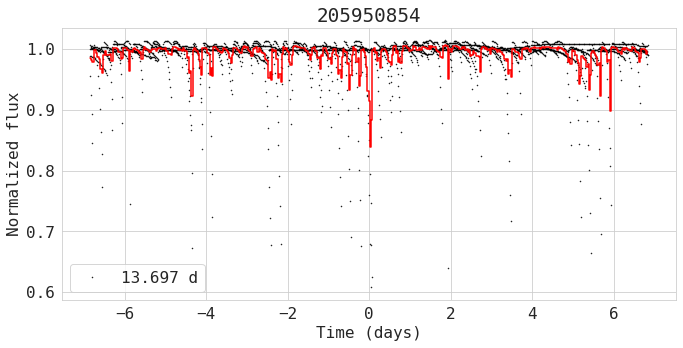

In [821]:
c3_small_df['fig'][2]

In [822]:
c3_small_df

,obs_id,campaign,lc_start,lc_end,maxpower,period,transit,duration,mean,median,stddev,sap_flux_norm,fig
0,206119924,c03,2.456977e+06,2.457046e+06,59001,30.265101250430195 d,2014-12-08T22:09:16.505,0.2 d,986762.125 electron / s,990518.5625 electron / s,9846.611328125 electron / s,"[0.9985837936401367, 0.9987229704856873, 0.998...",Figure(792x360)
1,205904628,c03,2.456977e+06,2.457046e+06,11035,0.4905320156305363 d,2014-11-15T15:39:29.826,0.2 d,7335161.0 electron / s,7335725.0 electron / s,5087.771484375 electron / s,"[1.0013424158096313, 1.001400113105774, 1.0013...",Figure(792x360)
2,205950854,c03,2.456977e+06,2.457046e+06,58045,13.697307251100613 d,2014-11-27T08:13:38.048,0.2 d,186227.234375 electron / s,186165.0625 electron / s,1278.8638916015625 electron / s,"[1.010563611984253, 1.0106163024902344, 1.0105...",Figure(792x360)


In [750]:
c3_dict = dict(zip(campaign3, c3_files))

In [751]:
c3_dict['K2-1']

'ktwo206432863-c03_llc.fits'

In [754]:
k2c3_df['target'] = campaign3

In [755]:
k2c3_df['target']

0     K2-116
1     K2-167
2     K2-168
3     K2-169
4     K2-170
5     K2-171
6     K2-172
7      K2-21
8     K2-265
9      K2-28
10     K2-39
11     K2-54
12     K2-55
13     K2-57
14     K2-58
15     K2-59
16     K2-60
17     K2-61
18     K2-62
19     K2-63
20     K2-64
21     K2-65
22     K2-66
23     K2-68
24     K2-69
25     K2-70
26     K2-71
27     K2-72
28     K2-73
29     K2-74
30     K2-75
31      K2-1
Name: target, dtype: object

In [762]:
targ = campaign3[0]

In [773]:
def light_curves(df, targets):
    """
    planet_hunter(f=files[9], fmt='kepler.fits')
    
    args:
    - fits_files = takes array or single .fits file
    
    kwargs:
    - format : 'kepler.fits' or  'tess.fits'
    """
    from astropy.timeseries import TimeSeries
    import numpy as np
    from astropy import units as u
    from astropy.timeseries import BoxLeastSquares
    from astropy.stats import sigma_clipped_stats
    from astropy.timeseries import aggregate_downsample
    
    light_curves = {}
    
    for target in targets:
        timeseries = {}
        data = df.loc[df['target'] == targ]
        ts = data['ts']
        period = data['period']
        transit_time = data['transit']
    
        # fold the time series using the period 
        ts_folded = data['ts_folded']#ts.fold(period=period, epoch_time=transit_time)
    
        ## folded time series plot
        # plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
        # plt.xlabel('Time (days)')
        # plt.ylabel('SAP Flux (e-/s)')
        
        # downsample the time series by binning the points into bins of equal time 
        ts_binned = data['ts_binned']
        #ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.03 * u.day)  
        
        # final result
        fig = plt.figure(figsize=(11,5))
        plt.plot(ts_folded.time.jd, ts_folded['sap_flux_norm'], 'k.', markersize=1)
        plt.plot(ts_binned.time_bin_start.jd, ts_binned['sap_flux_norm'], 'r-', drawstyle='steps-post')
        plt.xlabel('Time (days)')
        plt.ylabel('Normalized flux')
        
        timeseries['fig'] = fig
        
        light_curves[target] = timeseries

    df = pd.DataFrame.from_dict(light_curves, orient='index')
    return df

In [736]:
test_file = c3_files[0]
test_file

'ktwo206119924-c03_llc.fits'

In [769]:
k2_61_df

,obs_id,campaign,lc_start,lc_end,maxpower,period,transit,ts,ts_folded,mean,median,stddev,ts_binned,target
17,206044803,c03,2.456977e+06,2.457046e+06,58887,26.44445042473992 d,2014-11-29T05:21:27.182,"[[2014-11-15T14:28:39.182, 0.00545065850019454...","[[12.824450424739918, 0.0054506585001945496 d,...",95882.84375 electron / s,95991.234375 electron / s,284.1104736328125 electron / s,"[[-13.216763448283603, 2592.0 s, 0.00368113256...",K2-61


In [766]:
k2_61_df = k2c3_df.loc[k2c3_df['target'] == 'K2-61']

In [776]:
light_curves(k2_61_df, targets='K2-61')

AttributeError: 'Series' object has no attribute 'time'

<Figure size 792x360 with 0 Axes>

In [730]:
K2 = {}
campaigns = ['c01','c02','c03','c04','c05','c06','c07','c08','c102',
             'c111','c12','c13','c14','c15','c16','c17','c18','c19']
for campaign in campaigns:
    K2[campaign] = [file for file in files if '-' + campaign + '_' in file]

In [733]:
len(K2['c03'])

32

In [731]:
K2['c14']

['ktwo201498078-c14_llc.fits',
 'ktwo248435473-c14_llc.fits',
 'ktwo248545986-c14_llc.fits']

transit_time: 2017-06-02T08:22:12.614
transit_time: 2017-06-24T14:07:23.408
transit_time: 2017-06-01T14:36:18.225


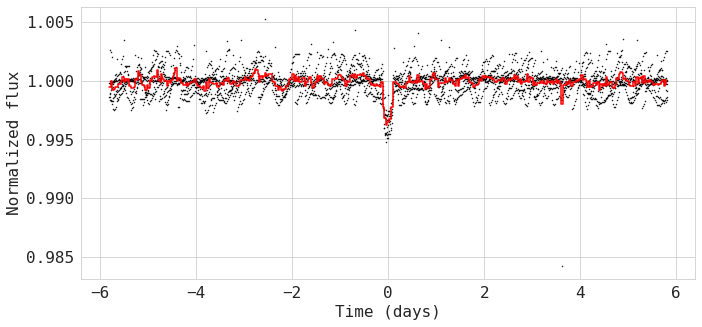

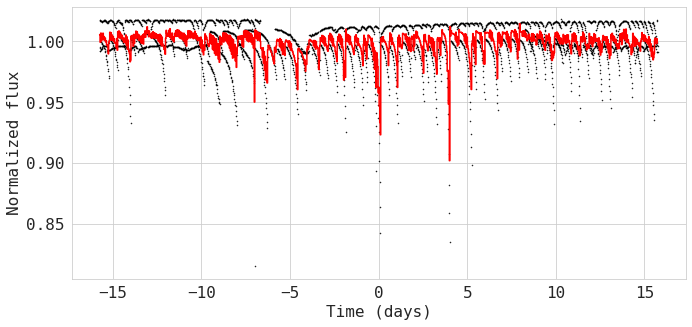

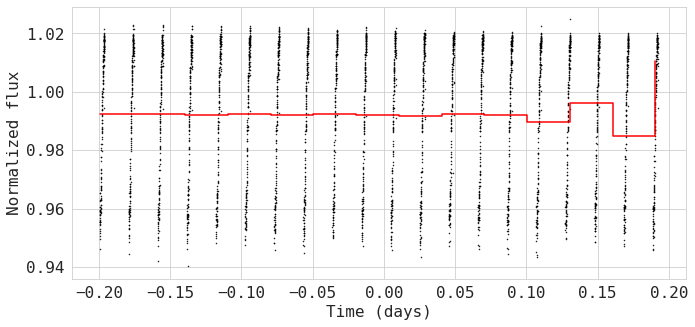

In [198]:
planet_hunter(file_list=K2['c14'], fmt='kepler.fits')

In [199]:
K2['c111']

['ktwo229426032-c111_llc.fits']

transit_time: 2016-09-30T09:28:34.948


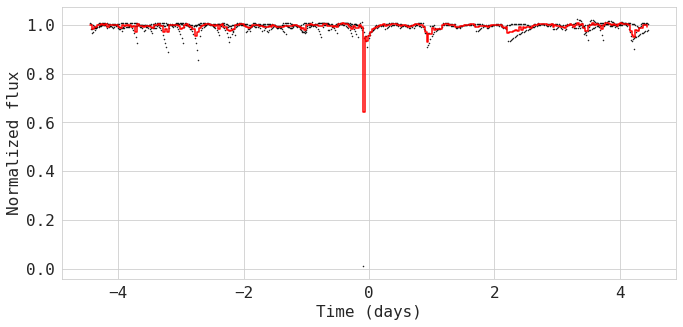

In [202]:
planet_hunter(K2['c111'])

### Fourier Periodogram

In [285]:
file = K2['c12'][0]
ts = TimeSeries.read(file, format='kepler.fits')

In [294]:
ts

time,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2016-12-15T21:02:47.381,5.039264e-03,136855,4.1193602e+04,6.0429826e+00,1.8712344e+03,8.9095551e-01,nan,nan,10000000000000000000,1044.73196,7.6680488e-05,247.88943,8.3006111e-05,1044.78822,2.0011830e-04,247.93401,1.6174708e-04,-1.2001304e-01,-1.7544615e-01
2016-12-15T21:32:12.721,5.037833e-03,136856,4.1070230e+04,6.0351734e+00,1.8742091e+03,8.8381660e-01,4.2273715e+04,6.7905793e+00,0,1044.69823,7.5580479e-05,247.88943,8.2519917e-05,1044.74637,2.0143474e-04,247.93612,1.6180836e-04,-1.5872276e-01,-1.7225918e-01
2016-12-15T22:01:38.060,5.036402e-03,136857,4.0906270e+04,6.0280766e+00,1.8710625e+03,8.8939810e-01,4.2278039e+04,6.7842360e+00,0,1044.66626,7.4959280e-05,247.88706,8.1610408e-05,1044.70640,2.0272918e-04,247.93580,1.6192219e-04,-1.9644962e-01,-1.7266949e-01
2016-12-15T22:31:03.400,5.034972e-03,136858,4.0717684e+04,6.0173841e+00,1.8714913e+03,8.8563567e-01,4.2278801e+04,6.7740507e+00,0,1044.63530,7.4929434e-05,247.88493,8.1180755e-05,1044.66582,2.0419457e-04,247.93641,1.6213245e-04,-2.3700853e-01,-1.7370421e-01
2016-12-15T23:00:28.739,5.033540e-03,136859,4.0530891e+04,6.0056615e+00,1.8699783e+03,8.8599199e-01,4.2287793e+04,6.7613697e+00,0,1044.60868,7.5598618e-05,247.88173,8.0864862e-05,1044.62977,2.0538218e-04,247.93548,1.6222682e-04,-2.7483684e-01,-1.7599967e-01
2016-12-15T23:29:54.078,5.032107e-03,136860,4.0304152e+04,5.9918852e+00,1.8721565e+03,8.9183956e-01,4.2286965e+04,6.7461653e+00,0,1044.58076,7.6703815e-05,247.87932,8.0754609e-05,1044.59185,2.0689185e-04,247.93478,1.6235519e-04,-3.1450313e-01,-1.7729656e-01
2016-12-15T23:59:19.417,5.030674e-03,136861,4.0010156e+04,5.9751115e+00,1.8724093e+03,8.8285273e-01,4.2295219e+04,6.7277236e+00,0,1044.54891,7.8935547e-05,247.87691,8.1059989e-05,1044.55061,2.0849673e-04,247.93444,1.6243455e-04,-3.6036032e-01,-1.7810458e-01
2016-12-16T00:28:44.757,5.029241e-03,136862,3.9627641e+04,5.9541502e+00,1.8733802e+03,8.8760543e-01,4.2283094e+04,6.7036772e+00,0,1044.51006,8.5294800e-05,247.87450,8.1045924e-05,1044.50503,2.1058969e-04,247.93268,1.6254731e-04,-4.1248348e-01,-1.7951110e-01


In [292]:
# Estimate period
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux', 'sap_flux_err')

best = np.argmax(results.power)
period = results.period[best]
print(period)

AttributeError: 'tuple' object has no attribute 'power'

In [293]:
ts.time

<Time object: scale='tdb' format='isot' value=['2016-12-15T21:02:47.381' '2016-12-15T21:32:12.721'
 '2016-12-15T22:01:38.060' ... '2017-03-04T17:20:53.336'
 '2017-03-04T17:50:18.647' '2017-03-04T18:19:43.968']>

## Import Negatives

Negative candidate samples to make up the majority class (host stars with no confirmed planets). The pre-training component of our model is to perform triage by accurately detecting and classifying flux signals as: 1) artifacts 2) eclipsing binaries or 3) possible planet(s). Only the andidates scoring above a certain prediction threshold for TCE probability will be selected for the next step (vetting).

📓 Time Series (at varying $\phi$)

### Spectral Cube

In [ ]:
# !pip install astropy spectral-cube
# !pip install astropy reproject

import astropy.units as u

from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file
# from astropy.utils import data
# data.conf.remote_timeout = 60
from spectral_cube import SpectralCube
from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

In [ ]:
# create astropy Table from pandas
# t2 = Table.read('data.csv', format='pandas.csv', sep=' ', names=['a', 'b', 'c'])

### Spectrum 1D

In [ ]:
# !pip install specutils

In [241]:
from specutils import Spectrum1D

spec1 = Spectrum1D(spectral_axis=np.arange(1, 50) * u.nm, flux=np.random.sample(49)*u.Jy)
spec2 = Spectrum1D(spectral_axis=np.arange(1, 50) * u.nm, flux=np.random.sample(49)*u.Jy)
spec3 = spec1 + spec2

flux1 = np.asarray(spec1.flux)
flux2 = np.asarray(spec2.flux)
make_specgram(flux1)
make_specgram(flux2)

### Normalize flux to local continuum

In [ ]:
# Normalize the flux to the local continuum
# In this example we want to look at the time evolution of a single specific 
# emission line in the spectrum. In order to estimate the equivalent width or 
# make reasonable plots we need to normalize the flux to the local continuum. 
# In this specific case the emission line is bright and the continuum can be 
# described reasonably by a second-order polynomial.

# So, we define two regions left and right of the emission line, where we fit 
# the polynomial. Looking at the figure, [3925*u.AA, 3930*u.AA] and 
# [3938*u.AA, 3945*u.AA] seem right for that. 
# Then, we normalize the flux by this polynomial.

# The following function will do that:

def region_around_line(w, flux, cont):
    '''cut out and normalize flux around a line

    Parameters
    ----------
    w : 1 dim np.ndarray
    array of wavelengths
    flux : np.ndarray of shape (N, len(w))
    array of flux values for different spectra in the series
    cont : list of lists
    wavelengths for continuum normalization [[low1,up1],[low2, up2]]
    that described two areas on both sides of the line
    '''
    #index is true in the region where we fit the polynomial
    indcont = ((w > cont[0][0]) & (w < cont[0][1])) |((w > cont[1][0]) & (w < cont[1][1]))
    #index of the region we want to return
    indrange = (w > cont[0][0]) & (w < cont[1][1])
    # make a flux array of shape
    # (number of spectra, number of points in indrange)
    f = np.zeros((flux.shape[0], indrange.sum()))
    for i in range(flux.shape[0]):
        # fit polynomial of second order to the continuum region
        linecoeff = np.polyfit(w[indcont], flux[i, indcont], 2)
        # divide the flux by the polynomial and put the result in our
        # new flux array
        f[i,:] = flux[i,indrange] / np.polyval(linecoeff, w[indrange].value)
    return w[indrange], f

wcaII, fcaII = region_around_line(wavelength, flux,
    [[3925*u.AA, 3930*u.AA],[3938*u.AA, 3945*u.AA]])

### Lightkurve

In [ ]:

# !pip install lightkurve
#import lightkurve as lk
# Finding periodic signals
# The lightkurve.periodogram module provides classes to help find periodic signals in light curves.

# Periodogram(frequency, power[, nyquist, …])

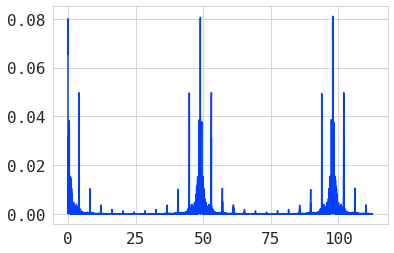

In [252]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle.from_timeseries(ts, 'sap_flux').autopower(method='fast')
plt.plot(frequency, power) 

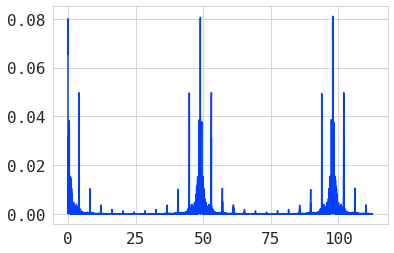

In [280]:
best = frequency[np.argmax(power)]
fig= plt.figure()
ax= plt.plot(frequency, power) 

plt.show()

In [233]:
def fourier_periodogram(t, y):
    N = len(t)
    frequency = np.fft.fftfreq(N, t[1] - t[0])
    y_fft = np.fft.fft(y.value) * y.unit
    positive = (frequency > 0)
    return frequency[positive], (1. / N) * abs(y_fft[positive]) ** 2

## Peak Stastics

In [ ]:
model = BoxLeastSquares(t * u.day, y, dy=0.01)
periodogram = model.autopower(0.2)
max_power = np.argmax(periodogram.power)
stats = model.compute_stats(periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])

# FITS image

In [317]:
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

In [360]:
image_data = fits.getdata('ktwo204890128-c02_llc.fits', ext=2)

In [361]:
print(image_data.shape)

(10, 11)


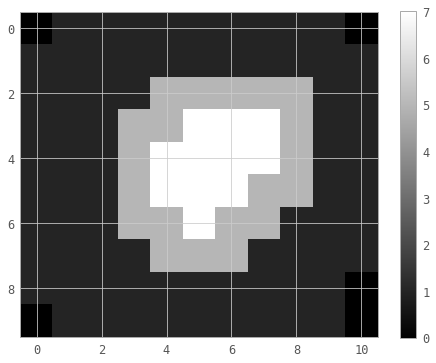

In [362]:
plt.figure()
plt.imshow(image_data, cmap='gray')
plt.colorbar()

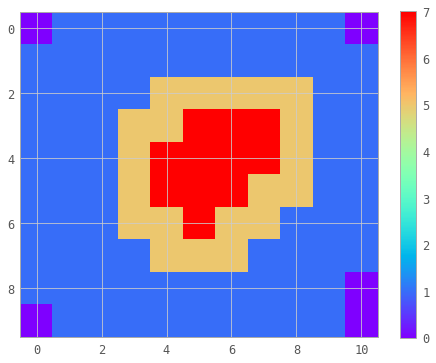

In [369]:
plt.figure()
plt.imshow(image_data, cmap='rainbow')
plt.colorbar()

In [375]:
# !pip install spectral_cube

In [374]:
from spectral_cube import SpectralCube

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS


In [378]:
# cube = SpectralCube.read('')

# Model

In [ ]:
# Uncomment below to install
# !pip install xgboost
# !pip install keras
# !pip install tensorflow
# !pip install imblearn

In [ ]:
### <---- IMPORT LIBRARIES ----> ####

## Preprocessing
# from imblearn.over_sampling import SMOTE # For imbalanced datasets
# from sklearn import preprocessing, linear_model, datasets, metrics
# from sklearn.preprocessing import StandardScaler
# from sklearn.externals import joblib
# import scipy.ndimage
# from scipy.ndimage import convolve
# from scipy.ndimage.filters import uniform_filter1d
# from sklearn.base import clone
# import random
#
## Data Pipeline - Model Selection
# from imblearn.pipeline import make_pipeline, Pipeline
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold
#
## Machine learning libraries
#
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
# from sklearn.decomposition import PCA
# from sklearn import svm
# from sklearn.svm import SVC
# from sklearn.svm import LinearSVC
# from sklearn import tree
# from sklearn.tree import DecisionTreeClassifier 
# from sklearn.tree import export_graphviz 
# from pydotplus import graph_from_dot_data
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from xgboost import XGBClassifier
#
## Neural Networks
#
# KERAS
# from keras.utils.np_utils import to_categorical
# from keras.preprocessing.text import Tokenizer
# from keras import models, layers, optimizers
# from keras.models import Sequential, Model
# from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
# BatchNormalization, Input, concatenate, Activation
# from keras.optimizers import Adam
# 
# RBM
# from sklearn.neural_network import BernoulliRBM
#
## Model Evaluation
# from sklearn.metrics import accuracy_score,roc_curve,auc,roc_auc_score, \
# average_precision_score, recall_score,precision_score,f1_score, \
# classification_report, make_scorer, confusion_matrix

# Signal Analysis - CNNs

### Bidirectional LSTM

In [ ]:

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# Image Analysis - Keras CNN

In [3]:
import os, glob, sys
from os import path

base_folder = r'specs/'
os.listdir(base_folder)

['test', 'train']

In [4]:
train_base_dir = base_folder+'train/'
test_base_dir = base_folder+'test/'

train_planets_dir = train_base_dir+'planets/'
train_negatives_dir = train_base_dir+'negatives/'

test_planets_dir = test_base_dir+'planets/'
test_negatives_dir = test_base_dir+'negatives/'

In [5]:
planet_train_files = glob.glob(train_planets_dir+'*.png')
negative_train_files = glob.glob(train_negatives_dir+'*.png')
all_train_files = [*planet_train_files, *negative_train_files]

planet_test_files = glob.glob(test_planets_dir+'*.png')
negative_test_files = glob.glob(test_negatives_dir+'*.png')
all_test_files = [*planet_test_files, *negative_test_files]

all_filename_vars = [planet_train_files, negative_train_files,
                     planet_test_files, negative_test_files]

In [6]:
def load_img_cv2(filename, RGB=True):
    import cv2
    IMG = cv2.imread(filename)
    
    if RGB: 
        cmap = cv2.COLOR_BGR2RGB
    
    else:
        cmap=cv2.COLOR_BGR2GRAY
        
    return cv2.cvtColor(IMG, cmap)


In [7]:
from PIL import Image
from keras.preprocessing import image
from imageio import imread
from skimage.transform import resize
from tqdm import tqdm

# defining a function to read images and convert to array
def read_img(img_path, target_size=(8,8)):
    #img = load_img_cv2(img_path)
    #img = image.img_to_array(img)
    img = image.load_img(img_path, target_size=target_size, interpolation='bilinear')
    img = image.img_to_array(img)
    return img

Using TensorFlow backend.


In [8]:
# Read in training and test filenames to produce X and y data splits.

def xy_arrays(planet_train_filenames, negative_train_filenames, 
              planet_test_filenames, negative_test_filenames, 
              img_size=(8,8)):
    # y labels are encoded as 0=negatives, 1=planets
    # returns X_train, X_test, y_train, y_test, y_val
    
    import numpy as np
    
    display('[i] LOADING IMAGES')
    X_img = []
    y_label = []
    
    for img_path in tqdm(planet_train_files):
        X_img.append(read_img(img_path, target_size=img_size))
        y_label.append(1)
        
    for img_path in tqdm(negative_train_files):
        X_img.append(read_img(img_path, target_size=img_size))
        y_label.append(0)
    
    for img_path in tqdm(planet_test_files):
        X_img.append(read_img(img_path, target_size=img_size))
        y_label.append(1)
        
    for img_path in tqdm(negative_test_files):
        X_img.append(read_img(img_path, target_size=img_size))
        y_label.append(0)
        
    from sklearn.model_selection import train_test_split
    X = np.array(X_img, np.float32)
    y = np.array(y_label)
    
    return X, y

In [11]:
X, y = xy_arrays(planet_train_files, negative_train_files, 
              planet_test_files, negative_test_files, 
              img_size=(64,64,3))

'[i] LOADING IMAGES'

100%|██████████| 5/5 [00:00<00:00, 48.90it/s]


In [12]:
X.shape, y.shape

((84, 64, 64, 3), (84,))

In [15]:
X[0][1]

array([[254., 229., 222.],
       [251., 150., 119.],
       [251., 143., 108.],
       [157.,  92.,  74.],
       [ 20.,  20.,  24.],
       [ 22.,  20.,  25.],
       [163.,  73.,  79.],
       [237., 100., 107.],
       [238., 104., 107.],
       [248., 130., 106.],
       [250., 136., 106.],
       [242., 120., 108.],
       [228.,  91., 113.],
       [228.,  90., 113.],
       [220.,  84., 117.],
       [214.,  81., 120.],
       [211.,  80., 121.],
       [184.,  69., 131.],
       [177.,  66., 134.],
       [186.,  70., 130.],
       [218.,  84., 118.],
       [221.,  85., 117.],
       [215.,  82., 120.],
       [208.,  77., 124.],
       [207.,  77., 124.],
       [171.,  64., 133.],
       [153.,  59., 138.],
       [156.,  59., 137.],
       [175.,  66., 134.],
       [178.,  66., 133.],
       [192.,  72., 128.],
       [215.,  81., 120.],
       [214.,  81., 120.],
       [180.,  68., 130.],
       [159.,  60., 137.],
       [166.,  65., 134.],
       [230., 106., 109.],
 

In [159]:
# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD

# #############################################################################
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [160]:
X, Y = nudge_dataset(X, y)

In [170]:
X.shape

(420, 64, 64, 3)

In [161]:
Y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [162]:
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

In [163]:
X.shape, y.shape

((420, 64, 64, 3), (84,))

In [ ]:
# X_train,X_test,X_val,y_train,y_test,y_val=load_train_test_val(planet_train_files, 
#                                                               negative_train_files,
#                                                               planet_test_files, 
#                                                               negative_test_files, 
#                                                               val_size=0.1, 
#                                                               img_size=(64,64,3))


#     X_train,X_val, y_train, y_val = train_test_split(X,y,test_size=0.1)
    
#     print('\n[i] Length of Splits:')
#     print(f"X_train={len(X_train)}, X_test={len(X_test)}, X_val={len(X_val)}")
    
#     return X_train, X_test, X_val, y_train, y_test, y_val

In [164]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

In [166]:
# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [167]:
# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

In [169]:
# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

ValueError: Found array with dim 4. Estimator expected <= 2.

In [138]:
# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

ValueError: Found array with dim 4. Estimator expected <= 2.

In [ ]:
# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

In [ ]:
# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()